In [2]:
import sys 
sys.path.insert(0,'../')

In [24]:
from IO import*
from data import* 
from Unet_models import*

import h5py as h5
import patchify as patch
import cv2

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")

2 Physical GPUs, 2 Logical GPUs


2022-03-10 17:16:50.832190: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-10 17:16:51.834682: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14635 MB memory:  -> device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0000:61:00.0, compute capability: 7.0
2022-03-10 17:16:51.836058: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 14635 MB memory:  -> device: 1, name: Tesla V100-PCIE-16GB, pci bus id: 0000:db:00.0, compute capability: 7.0


In [5]:
tf.keras.mixed_precision.experimental.set_policy('mixed_float16')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPUs will likely run quickly with dtype policy mixed_float16 as they all have compute capability of at least 7.0


## 1. Prepare data

In [6]:
data_path = '/home/m_fokin/NN/Data/data_exp2/exp2_time_19p6_101_102_107to110_113to185.h5'
f =h5.File(data_path,'r')
dsets = list(f.keys())
data = np.array(f[dsets[25]], dtype = np.uint8)
f.close()

In [7]:
patch_data = patch.patchify(data, (256, 256, 256), (128, 242, 242))

## 2. Segment grains

### 2.1. U-net segmentation

In [8]:
# data patches segmentation
batch_size = 1

model = UNet_3D(input_size = (256,256,256,1))
model.load_weights("/home/m_fokin/NN/Unet_3D_2D/UNet_3D__16_256.hdf5")

segmented = np.zeros(patch_data.shape, dtype = np.float32)

if (patch_data.max() > 1):
    patch_data = patch_data / patch_data.max() 
    
N = patch_data.shape[0] * patch_data.shape[1] * patch_data.shape[2]
patch_data_merged = patch_data.reshape((N, patch_data.shape[3], patch_data.shape[4], patch_data.shape[5]))

vol = patch_data_merged
vol  = np.reshape(vol, vol.shape + (1,))
vol  = vol.astype(np.float32)
result = model.predict(vol, verbose=1, batch_size = batch_size)
segmented = result.reshape(patch_data.shape) 

2022-03-10 17:17:20.122170: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8101


75/75 [==============================] - 14s 149ms/step


### 2.2. Volume reconstruction

In [9]:
recon = recon_3D(data_patches = segmented, patch_step = (128,242,242), patch_size = (256, 256, 256), recon_shape = (512, 1224, 1224))

In [12]:
recon[recon >= 0.8] = 1 
recon[recon < 0.8] = 0 

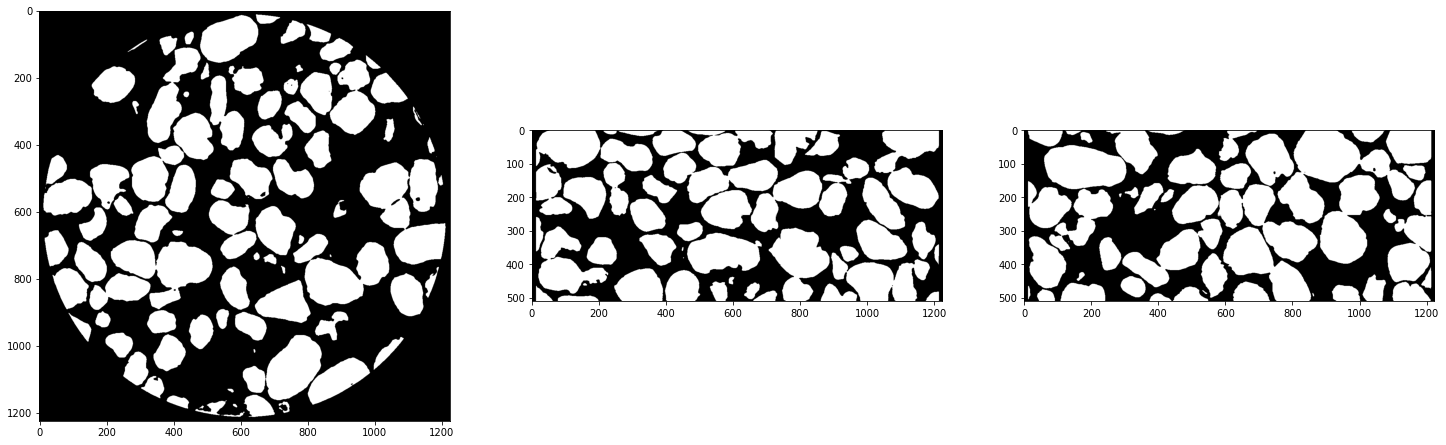

In [13]:
plt.figure(figsize = (25,25))

plt.subplot(1,3,1)
plt.imshow(recon[256,:,:], cmap = 'gray')

plt.subplot(1,3,2)
plt.imshow(recon[:,612,:], cmap = 'gray')

plt.subplot(1,3,3)
plt.imshow(recon[:,:,612], cmap = 'gray')

## 3. GMM segmentation

### 3.1. Extract grains 

In [20]:
mask = circle_mask(size = 1224, radius = 599)

In [32]:
type(recon[0,0,0])

numpy.float64

In [21]:
data = data * (1 - recon) * mask

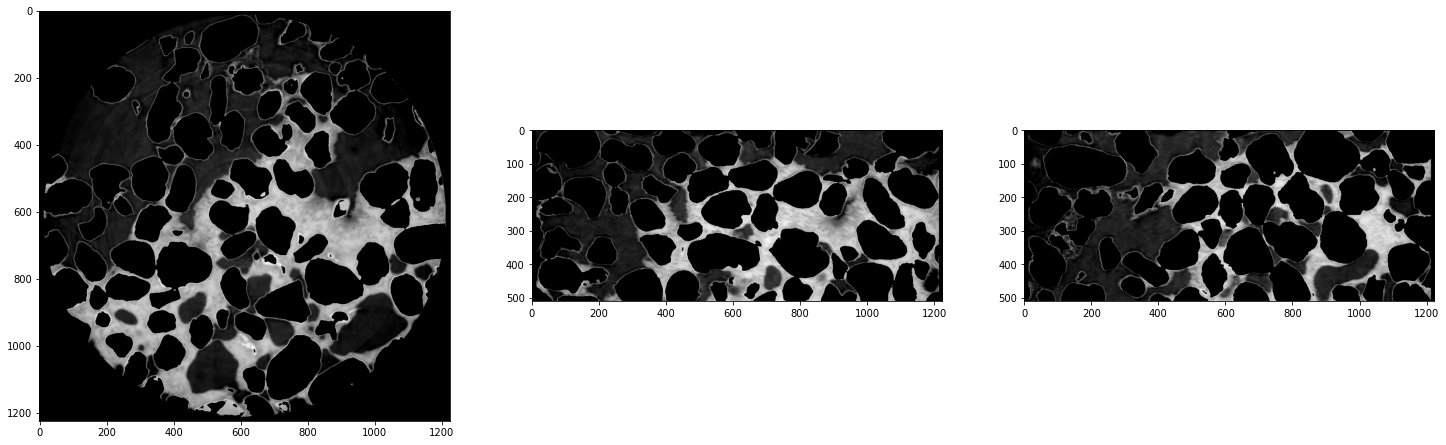

In [22]:
plt.figure(figsize = (25,25))

plt.subplot(1,3,1)
plt.imshow(data[256,:,:], cmap = 'gray')

plt.subplot(1,3,2)
plt.imshow(data[:,612,:], cmap = 'gray')

plt.subplot(1,3,3)
plt.imshow(data[:,:,612], cmap = 'gray')

### 3.2. Fit GMM

In [23]:
data_step = 50 

# 2d to 1d 
data_1d = data.ravel()
data_1d = data_1d[data_1d != 0] 
# Fit GMM
gmm = GaussianMixture(n_components = 4, max_iter=200, tol=1e-3, covariance_type = 'full', verbose = 0)               
gmm = gmm.fit(X = np.expand_dims(data_1d[::data_step],1))
# get params from GMM 
cov = gmm.covariances_
means = gmm.means_
weights = gmm.weights_

In [33]:
data = data.astype(np.float32)

In [34]:
hist_3D = np.zeros([256, 1], dtype = np.float32)
for i in range (data.shape[0]):
    hist = cv2.calcHist([data[i,:,:]],[0],None,[256],[0,256])
    hist[0] = 0
    hist_3D = hist_3D + hist

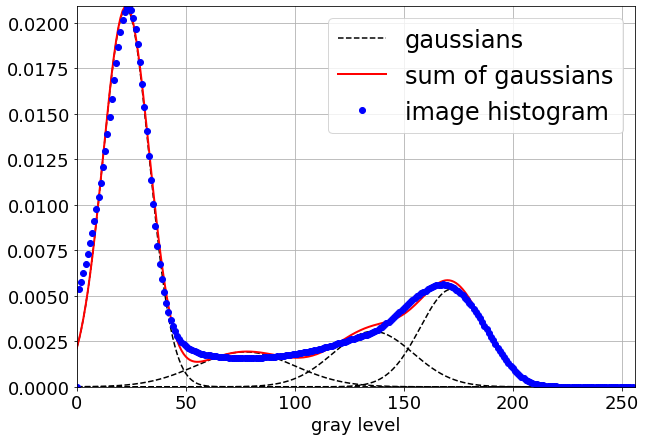

In [35]:
gmm_x = np.linspace(0,255,256)
gmm_y = np.exp(gmm.score_samples(gmm_x.reshape(-1,1)))

g1 = univariate_normal(gmm_x, means[0], cov[0][0]) * weights[0]
g2 = univariate_normal(gmm_x, means[1], cov[1][0]) * weights[1]
g3 = univariate_normal(gmm_x, means[2], cov[2][0]) * weights[2]
g4 = univariate_normal(gmm_x, means[3], cov[3][0]) * weights[3]

norm = gmm_y.max()/hist_3D.max()
xmax = (hist_3D * norm).max()
 
plt.figure(figsize = (10,7))
plt.grid()
plt.plot(g1, 'k--', label = "gaussians")
plt.plot(g2, 'k--')
plt.plot(g3, 'k--')
plt.plot(g4, 'k--')
plt.ylim(0, xmax)
plt.xlim(0, 256)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('gray level', fontsize = 18)
plt.plot(gmm_x, gmm_y, color="r", lw=2, label="sum of gaussians")
plt.plot(hist_3D * norm, 'bo', label="image histogram")
plt.legend(prop={'size': 24})